## Quantum Simulation of the $H_2$ Molecule

In [135]:
import qiskit as qk
from qiskit_nature import settings
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import Statevector
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, TrotterQRTE
from qiskit.synthesis import SuzukiTrotter
from qiskit_nature.operators.second_quantization import FermionicOp

import numpy as np
import matplotlib.pyplot as plt

settings.use_pauli_sum_op = False

## Quantum Simulation of $H_2$ Molecule using Qiskit

### **Defining the Molecule**:
- Utilize Qiskit's `PySCFDriver` to define the $H_2$ molecule.

### **Hamiltonian Transformation**:
- The electronic structure of the $H_2$ molecule is initially described in terms of fermionic creation and annihilation operators.
- Transform this fermionic Hamiltonian into a qubit (spin) Hamiltonian suitable for quantum computation.
- Two common transformations are:
  - **Jordan-Wigner Transformation**: Provides a direct mapping of fermions to qubits.
    - $ a_j \rightarrow \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $
    - $ a_j^\dagger \rightarrow \frac{1}{2} (X_j - i Y_j) \prod_{k=1}^{j-1} Z_k $


In [136]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', basis='sto3g') # H2 molecule with bond length 0.735 angstrom
molecule = driver.run() 
mapper = JordanWignerMapper()

# Now we get the second quantized Hamiltonian
hamiltonian = molecule.hamiltonian.second_q_op()

# By obtaining this Hamiltonian in the second quantized form, we are then set up to transform it into a qubit representation
h2_hamiltonian = mapper.map(hamiltonian)


**Determine the HF Configuration:** 
   For a molecule like $H_2$, the Hartree-Fock (HF) ground state may be represented as $|1s_\downarrow 1s_\uparrow \rangle$, where $1s_\downarrow$ and $1s_\uparrow$ indicate the spin-down and spin-up slots of the $1s$ orbital.

**Translate to Qubit Representation using Jordan-Wigner Transformation:** 
   Each molecular orbital has a spin-up and spin-down slot, for a total of four lots represented by four qubits. An occupied slot is represented by a qubit in state $|1 \rangle$ and an unoccupied slot by $|0 \rangle$. For $H_2$, the ground state becomes $|1100 \rangle$.

**Convert to Statevector:** 
   The state $|1100 \rangle$ corresponds to the vector:
   $$
   |1100\rangle = \begin{bmatrix} 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   1 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 
   \end{bmatrix}
   $$

**Note**
   Since our molecule has two electrons, and these are fermions, each eigenstate will require two qubits in the state $|1 \rangle$ and two qubits in the state $|0 \rangle$.

In [137]:
# Create the initial state that we will use later
initial_state = Statevector.from_label("1100")

### **A) Quantum Simulation**

Now, we will simulate the molecule to obtain its ground state using the **Variational Quantum Eigensolver (VQE)** method.

The **ansatz** prepares quantum states with parameters, $ \theta_k $, which are optimized by VQE:

$$ U(\theta) = e^{-i \theta_k H_k} $$

#### TwoLocal Ansatz

The `TwoLocal` ansatz in Qiskit is a quantum circuit template used for variational algorithms like VQE. It alternates between:
1. Single-qubit rotations: $RY$ gates.
2. Two-qubit entanglements: $CZ$ gates.

This structure provides a balance between expressiveness and computational efficiency, making it a popular choice for approximating quantum states.


In [138]:
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

### **Optimization Algorithm**

**COPYLA** is an optimizer used to minimize the expectation value of the energy:

$$ \min_{\theta} \langle \psi(\theta) | H | \psi(\theta) \rangle $$


In [139]:
# optimizer = COBYLA(maxiter=20)
optimizer = COBYLA(maxiter=20)

### **Ground state**

Now that we've set up the problem, let's define the quantum backend and proceed with the actual simulation.


In [140]:
backend = qk.Aer.get_backend('statevector_simulator')

In [141]:
# Setting up the VQE Algorithm
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 25})
qe_program = VQE(aer_estimator, ansatz, optimizer)

In [142]:
result = qe_program.compute_minimum_eigenvalue(operator=h2_hamiltonian)
print(f"Ground state energy: {result.eigenvalue.real} Ha")

Ground state energy: -1.3817510774774315 Ha


For the $H_2$ molecule at a bond length of approximately $0.735$ angstroms, the ground state energy is approximately $-1.174$ Hartree ([source](https://irinsubria.uninsubria.it/bitstream/11383/1715315/1/JCP_H2_1sigma_g.pdf)).



# **B) Simulating the $H_2$ Molecule**

Now, we will use **trotterization** to see how the $H_2$ molecule evolves.


In [143]:
#  We define the final time and the number of time steps
final_time = 1.6
num_timesteps = 20

# In this case our initial state is a superposition
initial_state= (Statevector.from_label('1100') + Statevector.from_label('1010')) / np.sqrt(2)

# Then we define the TimeEvolutionProblem object. We added the Hamiltonian as 
# an auxiliary operator so that we can compute the energy at each time step.
evolution_problem = TimeEvolutionProblem(h2_hamiltonian, initial_state=initial_state, time=final_time, aux_operators=[h2_hamiltonian])

In [144]:
# The estimator is used to compute the expectation values of the Hamiltonian
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
result = trotter.evolve(evolution_problem)

# This gives the circuit that evolves the initial state to the final state
evo_circuit = result.evolved_state 

# Get the expectation values of the Hamiltonian
observables = np.array(np.array(result.observables)[:, :, 0]) 

### **Trotter Results**

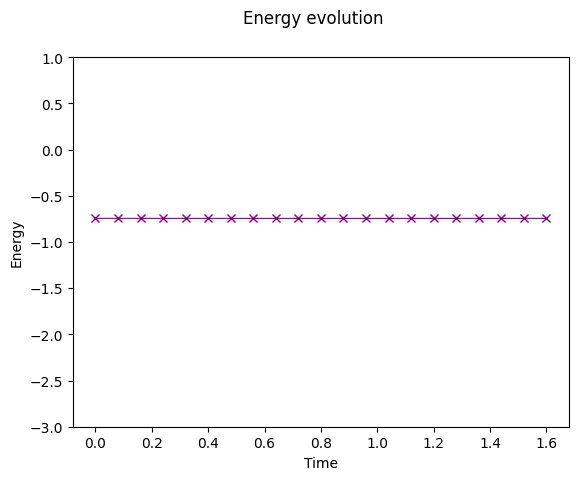

In [145]:
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables[:, 0], marker='x', label='First order', c='darkmagenta', ls='-', lw=.8)
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
plt.ylim(-3 ,1)
fig.suptitle("Energy evolution")
plt.show()

### **Exact Results**
Let's compare the values we got from Trotter evolution with the exact ones.

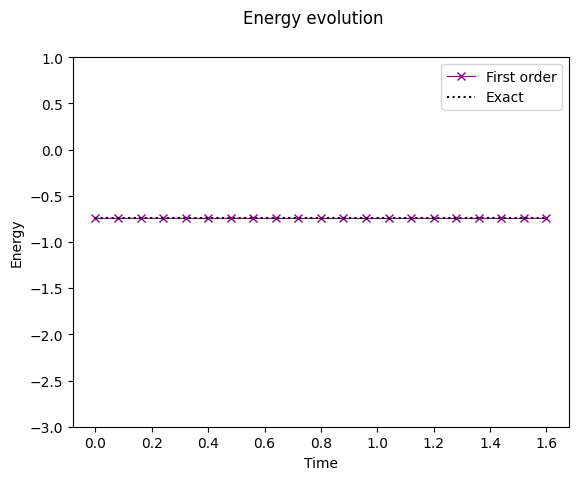

In [146]:
import scipy as sc

H_array = h2_hamiltonian.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(h2_hamiltonian) for sv in exact_evolution])
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes.legend()
fig

## **C) Time independent perturbation**

To introduce a new dynamic to our system, we will apply a perturbation. In the quantum domain, a perturbation can be represented by an additional term in the Hamiltonian that adds complexity to the system.

The perturbation function we're employing has the form:

$$
H_{\text{perturbation}} = -h \left( \sum_{i=0}^{N-1} \sin(\alpha) Z_i + \cos(\alpha) X_i \right)
$$

where:

- $N$ is the number of qubits in the system.
- $h$ is a scaling factor for the perturbation.
- $\alpha$ is an angle that controls the balance between the $Z$ and $X$ terms in the perturbation.
- $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X matrices operating on the $i$-th qubit, respectively.



In [147]:
from qiskit.quantum_info import SparsePauliOp
from math import pi

In [148]:
def perturbation(N: int, h : float, alpha : float = 0) -> SparsePauliOp:
    """
    Callable perturbation for the H2 Hamiltonian.

    Parameters
    ----------
    N : int
            Number of qubits in the system.
    h : float
            Amplitude of the perturbation.
    alpha : float
            Angle to distribute the weight among the Zi and Xi gates.

    Returns
    -------
    SparePauliOp :
            Representation of the perturbation as a Hamiltonian.
    """
    Z_tuples = [('Z', [i], -h * np.sin(alpha)) for i in range(0, N)]
    X_tuples = [('X', [i], -h * np.cos(alpha)) for i in range(0, N)]

    hamiltonian = SparsePauliOp.from_sparse_list([*Z_tuples, *X_tuples], num_qubits=N)
    return hamiltonian.simplify()

In [149]:
# This is the Hamiltonian of the molecule with the perturbation
pert_H = h2_hamiltonian + perturbation(4, 1, alpha=pi/8)

In [150]:
final_time = 10
num_timesteps = 60

#  Create the initial state and the evolution problem
initial_state=Statevector.from_label('1010')
evolution_problem = TimeEvolutionProblem(pert_H, initial_state=initial_state, time=final_time, aux_operators=[pert_H])

# Second and fourth order Trotter formula
second_order_formula = SuzukiTrotter(order=2) 
fourth_order_formula = SuzukiTrotter(order=4)

# Creates a Trotter object with the estimator and the product formula for each order
trotter1 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
trotter2 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=second_order_formula) 
trotter4 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=fourth_order_formula)

result1 = trotter1.evolve(evolution_problem)
result2 = trotter2.evolve(evolution_problem)
result4 = trotter4.evolve(evolution_problem)

evo_circuit1 = result1.evolved_state
evo_circuit2 = result2.evolved_state
evo_circuit4 = result4.evolved_state

observables1 = np.array(np.array(result1.observables)[:, :, 0])
observables2 = np.array(np.array(result2.observables)[:, :, 0])
observables4 = np.array(np.array(result4.observables)[:, :, 0])

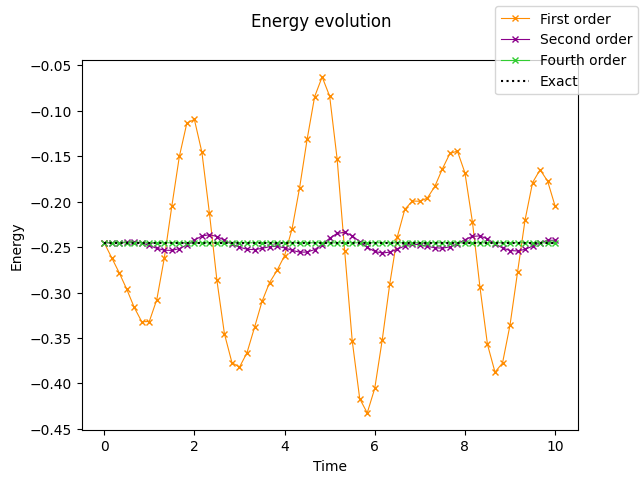

In [151]:
#  We get the eaxct evolution
H_array = pert_H.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(pert_H) for sv in exact_evolution])

# Plots the results
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables1[:, 0], marker='x',markersize=4, label='First order', c='darkorange', ls='-', lw=.8)
axes.plot(times, observables2[:, 0], marker='x',markersize=4, label='Second order', c='darkmagenta', ls='-', lw=.8)
axes.plot(times, observables4[:, 0], marker='x',markersize=4, label='Fourth order', c='limegreen', ls='-', lw=.8)
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
fig.suptitle("Energy evolution")
fig.legend()
plt.show()

## Exploring the effect of Field Direction on $H_2$ Molecule Evolution
Now, we turn our attention to understanding how the direction of the magnetic field impacts the time evolution of the $H_2$ molecule.

We will calculate the probabilities of each state at the end of the evolution for each angle



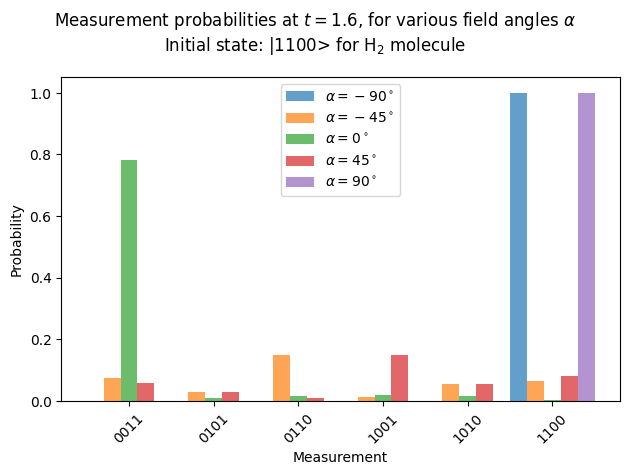

In [152]:
bar_width = .1
initial_state = Statevector.from_label("1100")
final_time = 1.6
eps = 1e-5

alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)
num_alphas = len(alphas)
num_states = 16
bar_positions = np.arange(num_states) * num_alphas * bar_width

# Wa are only interested in the states with two electrons
all_valid_labels = set()

for i, alpha in enumerate(alphas):
    H_alpha = h2_hamiltonian + perturbation(4, 1, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter2.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    
    # Filtering out the states with two electrons
    valid_keys = [key for key in amplitudes_dict.keys() if sum(map(int, key)) == 2]
    labels = valid_keys
    values = [amplitudes_dict[key] for key in valid_keys]
    
    all_valid_labels.update(labels)  # Add to our global list of valid labels
    
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(bar_positions[:len(labels)] + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

# Adjust x-ticks to be centered under the groups of bars
plt.xticks(bar_positions[:len(all_valid_labels)] + (num_alphas - 1) * bar_width / 2, sorted(all_valid_labels), rotation=45)

plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: |1100> for H$_2$ molecule"
)
plt.legend()
plt.tight_layout()
plt.show()

## **D) Time dependent Hamiltonian**

In [153]:
def t_perturbation(N, h, alpha=0, delta_t=0):
    """
    Parameters
    ----------
    N : int
            Number of qubits
    h : float
            Amplitude of the perturbation
    alpha : float
            Frequency of the perturbation 
    delta_t : float
            The time at which the hamiltonian is to be evaluated.

    Returns
    -------
    QuantumCircuit :
            A quantum circuit containing the Hamiltonian at time delta_t 
    """
    Z_tuples = [('Z', [i], -h * (1/np.exp(delta_t/2))*np.sin(alpha*delta_t)) for i in range(0, N)]
    X_tuples = [('X', [i], -h * (1/np.exp(delta_t/2))*np.cos(alpha*delta_t)) for i in range(0, N)]

    hamiltonian = SparsePauliOp.from_sparse_list([*Z_tuples, *X_tuples], num_qubits=N)
    return h2_hamiltonian + hamiltonian.simplify()

T = 10
n = 1000
delta_t = T/n
observables = []

# Now, we take inspiration from trotterization and create a naive implementation.

To time-evolve our state vector, we generate an evolution operator for each interval, `delta_t`. Given the small size of `delta_t`, this approach effectively acts as a first-order trotterization. Consequently, by multiplying all the evolution operators, we derive the cumulative effect. This method hinges on the premise that the matrix exponential remains accurate for minute `delta_t` values.


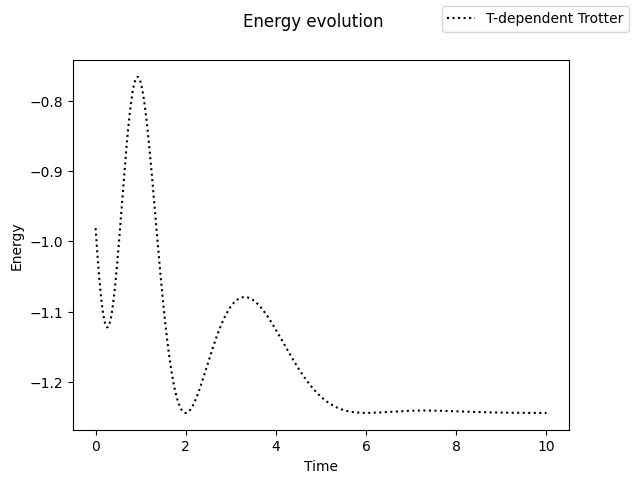

In [154]:
sv = Statevector.from_label("1100")

steps = np.linspace(0, T, n + 1)
t_dep_hamiltonians = [t_perturbation(4, 200, pi/4, step).to_matrix() for step in steps]

delta_t = T/n

#evolve the solution for every discrete interval delta_t
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * delta_t * ham_t)) for ham_t in t_dep_hamiltonians]

fig, axes = plt.subplots(1, sharex=True)
# We compute the exact evolution using the exp
exact_energy = np.real([sv.expectation_value(h2_hamiltonian) for sv in exact_evolution])
axes.plot(steps, exact_energy, c='k', ls=':', label='T-dependent Trotter')
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
fig.suptitle("Energy evolution")
fig.legend()
plt.show()

## E) **Adiabatic Transition**

To understand the Zeeman magnetic interactions in the context of quantum mechanics, we often consider perturbations applied to electron spins in an external magnetic field.

Consider an external magnetic field $\mathbf{B}$ with components in both the x and z directions. The Zeeman term that accounts for the interactions of electron spins with this external magnetic field is:

$$ H_Z = -g \mu_B \sum_i \mathbf{B} \cdot \mathbf{S_i} $$

Transitioning the Hamiltonian from the x-direction to the z-direction very slowly ensures the system remains in its ground state throughout the transition. This is pivotal for certain quantum algorithms, such as adiabatic quantum computation or quantum annealing, where the idea is to keep the system in its ground state while the Hamiltonian changes.



In [155]:
# This is the Hamiltonian of the magnetic field

def mf_hamiltonian(Bx: float, By: float, Bz: float) -> FermionicOp: 
    """
    Provides a Hamiltonian for the contribution from a magnetic field (Bx, By, Bz)
    to the Hydrogen molecule Hamiltonian.

    Parameters
    ----------
    Bx : float
            X-component of the magnetic field.
    By : float
            Y-component of the magnetic field.
    Bz : float
            Z-component of the magnetic field.
    
    Returns
    -------
    FermionicOp representation of the magnetic field acting on the Hydrogen molecule.
    """
    g = 2  # gyromagnetic ratio
    mu_B = 1 # 5.7883818012e-5  # Bohr magneton in eV/T

    num_orbitals = molecule.num_spatial_orbitals
    terms = []

    for i in range(num_orbitals):
        # Z-Component
        up_term_z = FermionicOp(f"+_{2*i} -_{2*i}")
        down_term_z = FermionicOp(f"+_{2*i+1} -_{2*i+1}")
        terms.append(Bz * 0.5 * (up_term_z - down_term_z))
        
        # X-Component
        up_down_term_x = FermionicOp(f"+_{2*i} -_{2*i+1}")
        down_up_term_x = FermionicOp(f"+_{2*i+1} -_{2*i}")
        terms.append(Bx * 0.5 * (up_down_term_x + down_up_term_x))
        
        # Y-Component
        up_down_term_y = 0.5j*FermionicOp(f"+_{2*i} -_{2*i+1}")
        down_up_term_y = -0.5j*FermionicOp(f"+_{2*i+1} -_{2*i}")
        terms.append(By * (up_down_term_y + down_up_term_y))

    return -g * mu_B * sum(terms)

#  We created the Hamiltonians for the different components of the magnetic field
z_hamiltonian = mapper.map(mf_hamiltonian(0,0,1))
x_hamiltonian = mapper.map(mf_hamiltonian(1,0,0))
y_hamiltonian = mapper.map(mf_hamiltonian(0,1,0))

## Integrated the Adiabatic Transition into our Hamiltonian

We create a perturbed Hamiltonian of the form

$$ \hat{H}(t)=\hat{H}_0 + \left(1-\frac{t}{\tau}\right)h_x\hat{P}_x+\frac{t}{\tau}h_z\hat{P}_z, $$

where $\hat{H}(t)$ is the total Hamiltonian as a function of time, $\hat{P}_x$ and $\hat{P}_z$ are the perturbations in the magnetic fields along the $x$- and $z$- axes, with amplitudes $h_x$ and $h_z$.


In [156]:
# This is the Hamiltonian of the molecule with the perturbation
# hx and hz are the amplitudes of the magnetic field
def perturbated_h(hx: float, hz: float, t: float, tau: float) -> SparsePauliOp:
    """
    The total perturbed Hamiltonian with contributions from a magnetic field,
    where the perturbation in the x-direction decreases linearly to 0 in time tau
    while the perturbation in the z-direction increases linearly from 0 in the same time.

    Parameters
    ----------
    hx : float
            Amplitude of the Hamiltonian perturbation from the x-pointing magnetic field
    hz : float
            Amplitude of the Hamiltonian perturbation from the z-pointing magnetic field
    t : float
            Current time at which to evaluate the Hamiltonian
    tau : float
            The time it takes for the perturbations to shift from one to the other.
    
    Returns
    -------
    Total Hamiltonian at time t including the perturbations.
    """
    return  h2_hamiltonian + (1-t/tau)*hx*x_hamiltonian+ t/tau*hz*z_hamiltonian

In [157]:
# This function simulates the evolution of the system from the ground state of the Hamiltonian
# with the magtenic field in the x direction to the ground state of the Hamiltonian with the
# magnetic field in the z direction

def simulate(hx, hz, tau, delta_t, steps):
    """
    A set of observables for the system beginning at the ground state
    and evolving with the time-dependent perturbation, as lists over the times in steps
    where the distance between steps is delta_t.

    Parameters
    ----------
    hx : float
            Amplitude of the Hamiltonian perturbation from the x-pointing magnetic field
    hz : float
            Amplitude of the Hamiltonian perturbation from the z-pointing magnetic field
    tau : float
            The time it takes for the perturbations to shift from one to the other.
    delta_t : float
            The time between each step used to evolve the system.
    steps : ListLike
            List of times over which to evolve the system
    
    Returns
    -------
    (List, List, List, List, Statevector) :
            Four lists of observables as well as the state at the end of the evolution.
    """
    eigenvalues, eigenvectors = np.linalg.eig(perturbated_h(hx, hz,0,tau).to_matrix())
    # Get the index of the smallest eigenvalue (i.e., the ground state energy)
    ground_state_idx = np.argmin(eigenvalues)
    current_state = eigenvectors[:, ground_state_idx]

    ground_state_vector = np.ascontiguousarray(eigenvectors[:, ground_state_idx])
    current_state = Statevector(ground_state_vector)


    observables = []
    observables2 = []
    observables3 = []
    observables4 = []
    t_dep_hamiltonians = [perturbated_h(hx,hz, step, tau) for step in steps]

    #evolve the solution for every discrete interval delta_t
    for ham_t in t_dep_hamiltonians:
        current_state = Statevector(current_state.evolve(sc.linalg.expm(-1j * delta_t * ham_t)))
        observables.append(current_state.expectation_value(ham_t).real)
        observables2.append(current_state.expectation_value(perturbated_h(hx,hz,tau, tau)).real)
        observables3.append(current_state.expectation_value(perturbated_h(hx,hz,0,tau)).real)
        observables4.append(min(np.linalg.eigvals(ham_t.to_matrix())).real)

    return observables, observables2, observables3, observables4, current_state

In [158]:
# This function plots the results of the simulation
def plot_results(observables, observables2, observables3, observables4, exact_initial_energy,exact_final_energy, steps):
    fig, axes = plt.subplots(1, sharex=True)

    # We compute the exact evolution using the exp
    axes.plot(steps, observables, c='k', ls=':', label='H(t)', lw = 2)
    axes.plot(steps, observables2, c='g', ls=':', label='Final Hamiltonian')
    axes.plot(steps, observables3, c='r', ls=':', label='Initial Hamiltonian')
    plt.axhline(y=exact_final_energy, color='g', linestyle='-', label='Final Energy', )
    plt.axhline(y=exact_initial_energy, color='r', linestyle='-', label='Initial Energy')
    plt.legend()
    axes.set_ylabel("Energy")
    axes.set_xlabel("Time")
    fig.suptitle("Energy evolution")
    plt.show()

## Energy Evolution (Case One)

First, we took perturbations with tremendous amplitudes, to show how the state evolves from the initial state to the final state. We see the black dotted line, representing the expectation value of the total Hamiltonian $\bra{\psi(t)}\hat{H}(t)\ket{\psi(t)}$, bows upward. This is due to the fact that we shift linearly from the perturbation in $x$ to the perturbation in $z$, so in the middle, the amplitude of the perturbation is at a minimum. The symmetry in this plot above is due to the overwhelming amplitude of the perturbation, stripping the structure of the molecule of any impact.

<div style="display: flex; justify-content: center;">
    <img src="X-MF.png" alt="Image 1" style="width: 30%; padding: 10px;">
    <img src="Z-MF.png" alt="Image 2" style="width: 30%; padding: 10px;">
</div>

In [159]:
# In this case, the magnetic fields have an amplitude much larger than the energy of the molecule
tau  = 10000
hz = 80
hx = hz
delta_t = 1
steps = np.linspace(0, tau, 1000)
observables1, observables2, observables3, observables4, current_state = simulate(hx, hz, tau, delta_t,steps)
exact_final_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,tau, tau)).real)
exact_initial_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,0,tau).to_matrix()).real)

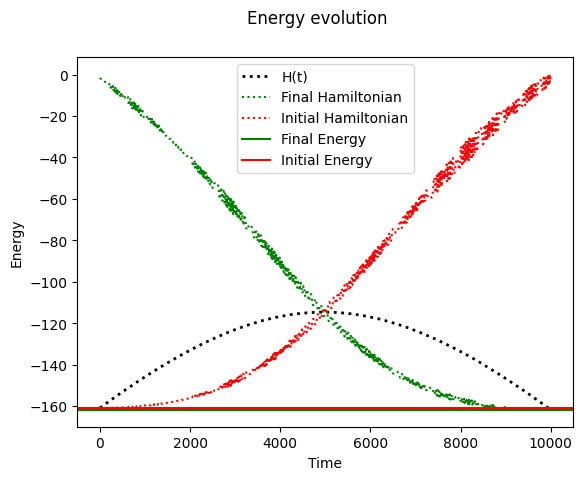

In [160]:
plot_results(observables1, observables2, observables3,observables4, exact_initial_energy, exact_final_energy, steps)

## Conclusions (Case Two)

In the end, we take realistic amplitudes for the perturbations, on the order of the ground state energy of the Hydrogen molecule. 

Please note that $\langle\hat{H}(0)\rangle$ is still a function of time, as we can evaluate the expectation value of that hamiltonian for the statevector as the statevector evolves according to a different Hamiltonian. The same is true for $\langle\hat{H}(\tau)\rangle$.

### Note One
The result shows a gap between the ground state energies of the $H_2+B_x$ Hamiltonian and the $H_2+B_z$ Hamiltonian. Our Hydrogen molecule is aligned along the $z$-axis, so there is an asymmetry between perturbations along the $z$-axis and in the $xy$-plane which explains this energy gap.

### Note Two
Our plots include the expectation values as functions of time: $\bra{\psi(t)}\hat{H}(0)\ket{\psi(t)}$ and $\bra{\psi(t)}\hat{H}(\tau)\ket{\psi(t)}$ and $\bra{\psi(t)}\hat{H}(t)\ket{\psi(t)}$. From these, we have derived two predictions which are reflecting in the results of our plot below.

#### The first prediction
The first prediction pertains to the first derivative of the expectation value $\langle\hat{H}\rangle$
$$ \frac{\partial}{\partial t}\langle\hat{H}(t)\rangle=\frac{\partial}{\partial t}\left[\left(1-\frac{t}{\tau}\right)\langle\hat{H}(0)\rangle+\frac{t}{\tau}\langle\hat{H}(\tau)\rangle\right] $$
$$ \frac{\partial}{\partial t}\langle\hat{H}(t)\rangle=\frac{1}{\tau}\left(\langle\hat{H}(\tau)\rangle-\langle\hat{H}(0)\rangle\right)+\left(1-\frac{t}{\tau}\right)\frac{\partial}{\partial t}\langle\hat{H}(0)\rangle+\frac{t}{\tau}\frac{\partial}{\partial t}\langle\hat{H}(\tau)\rangle $$

So at $t=0$ and $t=\tau$, we expect the slope of $\langle\hat{H}(t)\rangle$  to be simply $\frac{1}{\tau}\left(\langle\hat{H}(\tau)\rangle-\langle\hat{H}(0)\rangle\right)$. Prediction two will explain why this means that the initial slope will be zero while the final slope will be a non-zero negative value.

#### The second prediction
We expect the expectation value $\langle\hat{H}(0)\rangle$ to increase. This is because the molecule begins in the lowest energy eigenstate of $\hat{H}(0)$. Therefore, as the state evolves, its representation as a linear combination of the eigenstates of $\hat{H}(0)$ will necessary include contributions from higher-energy eigenstates, so the overall expectation value increases and never decreases below the initial value.

The exact same argument works in reverse for $\langle\hat{H}(\tau)\rangle$. 

#### Putting the pieces together.
Since our initial ground state energy is higher than our final ground state energy $\langle\hat{H}(0)\rangle$ and $\langle\hat{H}(\tau)\rangle$ can be made to be almost equal with the right choice of the amplitudes of the perturbations. Therefore, the derivative of the total expectation value will begin at zero.

So, that means that the expectation value will "gently depart" it's initial value.

However, by the same argument, $\langle\hat{H}(0)\rangle$ and $\langle\hat{H}(\tau)\rangle$ will have very different values at time $t=\tau$, so the derivative of the total expectation value will be non-zero, and our expectation value arrives at its final value with a bang!

In [161]:
# Now we use smaller amplitudes for the magnetic fields to see the effect
 # of the perturbation on the molecule
tau  = 250
hz = 0.5
hx = hz
delta_t = 1
steps = np.linspace(0, tau, tau)
observables1, observables2, observables3, observables4, current_state = simulate(hx, hz, tau, delta_t,steps)
exact_final_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,tau, tau)).real)
exact_initial_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,0,tau).to_matrix()).real)

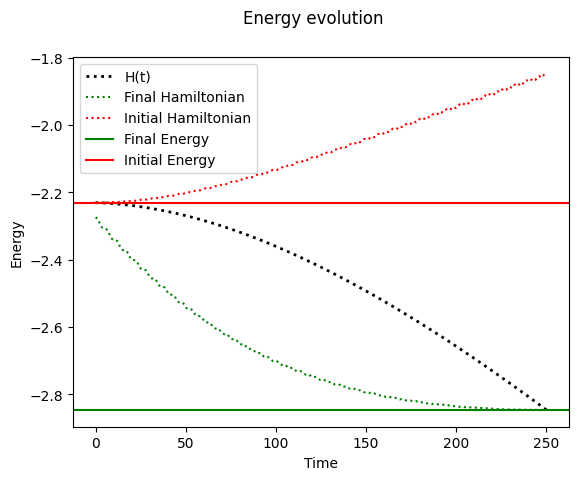

In [162]:
plot_results(observables1, observables2, observables3,observables4, exact_initial_energy, exact_final_energy, steps)

## Further Inquiry

It would be very interesting to see if the "arrive-with-a-bang" phenomenon has any real-world implications on the molecule. 